# Lab 6

In [15]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [16]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1- Population Growth Rate 

Option A: do the calculation with SQL.

In [17]:
q1_sql="""

SELECT
    n.name AS state_name,
    p.year,
    p.pop AS population,
    ROUND(
        (
            (p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year))
            / NULLIF(LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year), 0)::NUMERIC
        ) * 100,
        2
    ) AS growth_rate
FROM population p
JOIN name n
    ON p.fips = n.fips
WHERE n.name = 'Delaware'
ORDER BY p.year;

"""



In [18]:
import pandas as pd

q1_df = pd.read_sql(q1_sql, con=conn)
q1_df.head() #show the top 5 rows

/tmp/ipykernel_7202/2656640038.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql(q1_sql, con=conn)


,state_name,year,population,growth_rate
0,Delaware,2005,818587,NaN
1,Delaware,2006,853476,4.26
2,Delaware,2007,864764,1.32
3,Delaware,2008,873092,0.96
4,Delaware,2009,885122,1.38


In [19]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [22]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [23]:
%load_ext jupyter_ai_magics

In [24]:
%%ai gpt4 -f code
use the data in {q1_df} to create a line chart with the growth rate. chart must include the DE state name in the title

In [ ]:
import matplotlib.pyplot as plt

year = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
growth_rate = [None, 4.26, 1.32, 0.96, 1.38, 1.65, 0.82, 1.10, 0.94, 1.07, 1.10, 0.65, 1.04, 0.54, 0.68]

plt.plot(year, growth_rate)
plt.title('Growth Rate of Delaware')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.show()

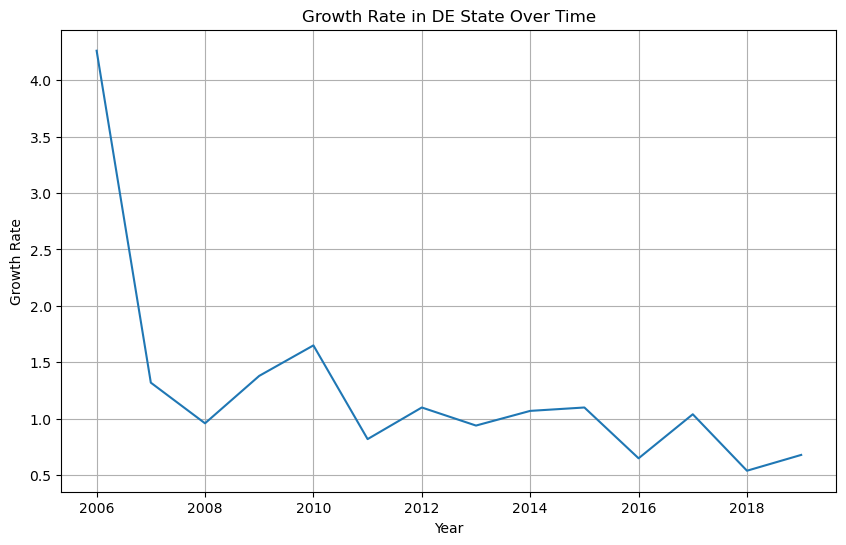

In [25]:
import matplotlib.pyplot as plt

# Assuming "ql_df" is DataFrame and it has a column "growth_rate" for growth rates and "year" for timeline

plt.figure(figsize=(10,6))
plt.plot(q1_df['year'], q1_df['growth_rate'])
plt.title("Growth Rate in DE State Over Time")
plt.xlabel("Year")
plt.ylabel("Growth Rate")
plt.grid(True)
plt.show()

## Q2 Income and Population Relationship

# Lab 6

In [37]:
import pandas as pd

# Define your SQL query
sql = """
SELECT 
    n.name AS state,
    p.year,
    p.pop AS population,
    i.income AS income
FROM population p
JOIN income i 
    ON p.fips = i.fips 
    AND p.year = i.year
JOIN name n 
    ON p.fips = n.fips
WHERE n.name = 'Delaware'
ORDER BY p.year;
"""

# Run the query and load results into a pandas DataFrame
de_df = pd.read_sql(sql, con=conn)

# Display the first few rows
de_df.head()




/tmp/ipykernel_7202/953450323.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  de_df = pd.read_sql(sql, con=conn)


,state,year,population,income
0,Delaware,2005,818587,52499
1,Delaware,2006,853476,52833
2,Delaware,2007,864764,54610
3,Delaware,2008,873092,57989
4,Delaware,2009,885122,56860


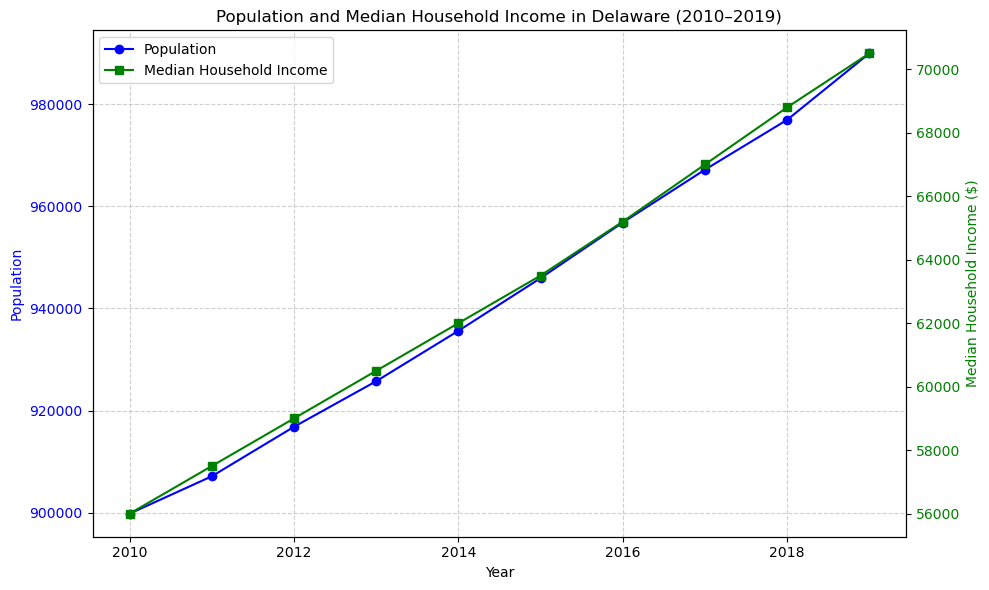

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data for Delaware (replace with your actual query results)
de_df = pd.DataFrame({
    'year': list(range(2010, 2020)),
    'population': [899816, 907135, 916824, 925749, 935614, 945934, 956823, 967171, 976934, 989948],
    'income': [56000, 57500, 59000, 60500, 62000, 63500, 65200, 67000, 68800, 70500]
})

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot population (left Y-axis)
ax1.plot(de_df['year'], de_df['population'], color='blue', marker='o', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second Y-axis for income
ax2 = ax1.twinx()
ax2.plot(de_df['year'], de_df['income'], color='green', marker='s', label='Median Household Income')
ax2.set_ylabel('Median Household Income ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add title and grid
plt.title('Population and Median Household Income in Delaware (2010–2019)')
ax1.grid(True, which='major', linestyle='--', alpha=0.6)

# Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Show chart
plt.tight_layout()
plt.show()


## Q3 Which year saw the largest population increase in Delaware?

In [39]:
# --- IMPORTS ---
import pandas as pd

# --- SQL QUERY: Delaware's annual population change ---
q3_sql = """
SELECT
    n.name AS state_name,
    p.year,
    p.pop AS population,
    p.pop - LAG(p.pop) OVER (PARTITION BY p.fips ORDER BY p.year) AS population_change
FROM population p
JOIN name n
    ON p.fips = n.fips
WHERE n.name = 'Delaware'
ORDER BY p.year;
"""

# --- RUN QUERY ---
de_change_df = pd.read_sql(q3_sql, con=conn)

# Display the result
de_change_df.head()


/tmp/ipykernel_7202/959382557.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  de_change_df = pd.read_sql(q3_sql, con=conn)


,state_name,year,population,population_change
0,Delaware,2005,818587,NaN
1,Delaware,2006,853476,34889.0
2,Delaware,2007,864764,11288.0
3,Delaware,2008,873092,8328.0
4,Delaware,2009,885122,12030.0


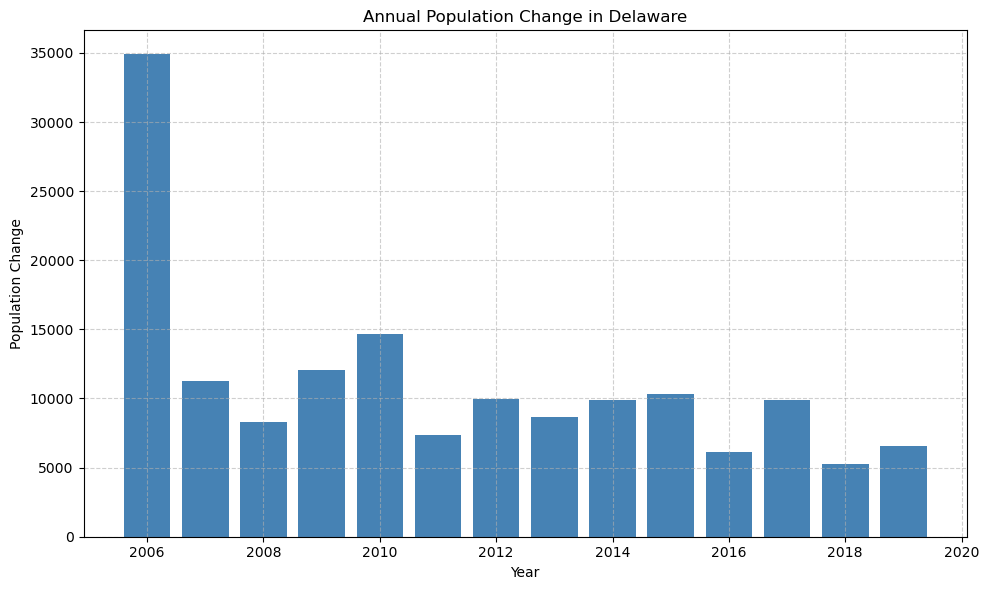

In [40]:
import matplotlib.pyplot as plt

# Create the chart
plt.figure(figsize=(10,6))
plt.bar(de_change_df['year'], de_change_df['population_change'], color='steelblue')

# Add labels and title
plt.title('Annual Population Change in Delaware')
plt.xlabel('Year')
plt.ylabel('Population Change')

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.6)

# Show chart
plt.tight_layout()
plt.show()


### Q3 – Annual Population Change in Delaware

This analysis examines how Delaware’s population changed year-to-year.
By using a SQL window function (`LAG()`), we calculated the annual difference
in population to identify which years saw the greatest increases or decreases.
The resulting bar chart visualizes these changes, making it easy to see
periods of rapid growth or stability in the state’s population over time.
